IMPORT

In [596]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.metrics import BinaryAccuracy, AUC, Accuracy
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras import preprocessing
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import random
import math

STANDARD VALUES

In [597]:
IMAGE_SIZE = 320
CHANNELS = 3
BATCH_SIZE = 16
EPOCHS = 2
IMAGES = 50
TRAIN_VALIDATION_SPLIT = 0.8
FEATURES = "Path"
LABELS = ["Pneumonia", "Edema", "Fracture"]
METRICS = ["binary_accuracy", "accuracy", AUC(name = "auc", multi_label = True)]

FUNCTIONS

In [598]:
def parse_image(features, label):
    image_string = tf.io.read_file(features)
    image = tf.image.decode_jpeg(image_string, channels = CHANNELS)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = image / 255.0
    
    return image, label

def create_dataset(dataframe):
    dataset = tf.data.Dataset.from_tensor_slices((dataframe[FEATURES].values, dataframe[LABELS].values))
    dataset = dataset.map(parse_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
    
    return dataset

def preprocess_dataset(dataset, is_training):
    dataset = dataset.cache().shuffle(10, reshuffle_each_iteration = False)
    
    if is_training == True:
        print(tf.data.experimental.cardinality(dataset))
        dataset_augmented = dataset.take(int(0.5*IMAGES*TRAIN_VALIDATION_SPLIT)).map(augment, num_parallel_calls = tf.data.experimental.AUTOTUNE)
        dataset = dataset.concatenate(dataset_augmented)
        print(tf.data.experimental.cardinality(dataset))

    dataset = dataset.batch(BATCH_SIZE).prefetch(buffer_size = tf.data.AUTOTUNE)
    
    return dataset

def augment(image, label):
    image = tfa.image.rotate(image, random.uniform(-10,10)*math.pi/180)
    image = tf.image.central_crop(image, random.uniform(0.9, 1.0))
    image = tf.image.random_brightness(image, max_delta = 0.1)
    image = tf.image.random_contrast(image, lower = 0.9, upper = 1.1)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    
    return image, label

def plot_training(history):
    history_dict = history.history
    
    for h in history_dict:
        plt.plot(history.history[h])
        plt.title(h)
        plt.ylabel(h)
        plt.xlabel("epochs")
        plt.show()
        
def show_examples(dataset, number):
    for a,b in dataset.unbatch().shuffle(IMAGES).take(number):
        plt.imshow(a)
        print(b.numpy())

DATA FRAME

In [599]:
dataframe = pd.read_csv("Chexpert/train.csv")

for l in LABELS:
    dataframe[l][dataframe[l] < 0] = 0
    dataframe[l] = dataframe[l].fillna(0)

dataframe = dataframe[dataframe["Frontal/Lateral"] != "Lateral"][:IMAGES]

dataframe["Patient"] = dataframe.Path.str.split('/',3,True)[2].str.split("patient", 2, True)[1] 
dataframe["Patient"] = [i.lstrip("0") for i in dataframe["Patient"]]

dataframe["Study"] = dataframe.Path.str.split('/',4,True)[3].str.split("study", 2, True)[1]
    
dataframe.head()

C:\Users\Admin\AppData\Local\Temp/ipykernel_8912/741237622.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[l][dataframe[l] < 0] = 0


,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,Patient,Study
0,Chexpert/train/patient00001/study1/view1_front...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,0.0,NaN,NaN,0.0,1.0,1,1
1,Chexpert/train/patient00002/study2/view1_front...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,...,-1.0,0.0,-1.0,NaN,-1.0,NaN,1.0,NaN,2,2
2,Chexpert/train/patient00002/study1/view1_front...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,...,-1.0,0.0,NaN,NaN,NaN,NaN,1.0,NaN,2,1
4,Chexpert/train/patient00003/study1/view1_front...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,3,1
5,Chexpert/train/patient00004/study1/view1_front...,Female,20,Frontal,PA,1.0,0.0,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,4,1


In [600]:
dataframe.shape

(50, 21)

CREATE DATASET

In [601]:
dataset = create_dataset(dataframe)

SPLIT DATASET

In [602]:
train_ds = dataset.take(int(TRAIN_VALIDATION_SPLIT*IMAGES))
valid_ds = dataset.skip(int(TRAIN_VALIDATION_SPLIT*IMAGES))

train_ds = preprocess_dataset(train_ds, True)
valid_ds = preprocess_dataset(valid_ds, False)

tf.Tensor(40, shape=(), dtype=int64)
tf.Tensor(60, shape=(), dtype=int64)


MODEL

In [603]:
base_model = DenseNet121(
    include_top = False, 
    weights = "imagenet", 
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),
    pooling = None
)

base_model.trainable = False

inputs = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = base_model(inputs, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
initializer = tf.keras.initializers.GlorotUniform(seed = 42)

activation =  tf.keras.activations.sigmoid

outputs = tf.keras.layers.Dense(
    len(LABELS),
    kernel_initializer = initializer,
    activation = activation
)(x) 

model = tf.keras.Model(inputs, outputs)

model.compile(
    loss = "binary_crossentropy",
    optimizer = "adam",
    metrics = METRICS
)

model.summary() 

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 320, 320, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 10, 10, 1024)      7037504   
                                                                 
 global_average_pooling2d_17  (None, 1024)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_17 (Dense)            (None, 3)                 3075      
                                                                 
Total params: 7,040,579
Trainable params: 3,075
Non-trainable params: 7,037,504
_________________________________________________________________


TRAINING

In [604]:
history = model.fit(train_ds, epochs = EPOCHS, validation_data = valid_ds)

Epoch 1/2
4/4 [==============================] - 36s 7s/step - loss: 0.6443 - binary_accuracy: 0.6500 - accuracy: 0.0833 - auc: 0.3781 - val_loss: 0.3131 - val_binary_accuracy: 0.8667 - val_accuracy: 0.2000 - val_auc: 0.1354
Epoch 2/2
4/4 [==============================] - 23s 6s/step - loss: 0.3389 - binary_accuracy: 0.8889 - accuracy: 0.0833 - auc: 0.3908 - val_loss: 0.2189 - val_binary_accuracy: 0.9333 - val_accuracy: 0.2000 - val_auc: 0.1458


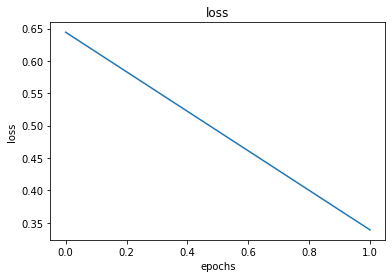

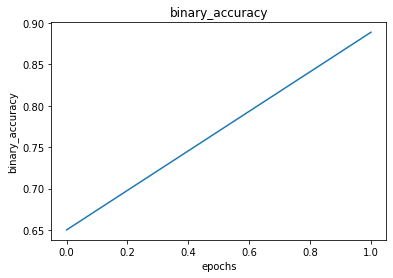

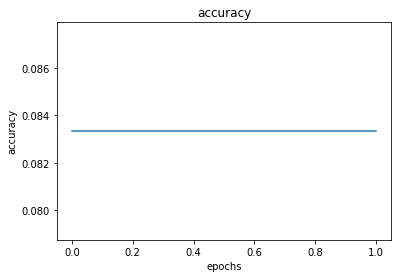

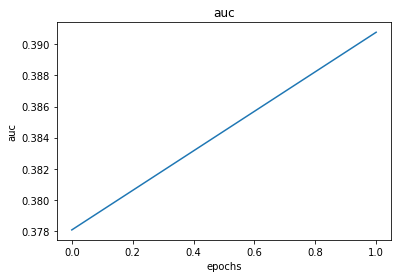

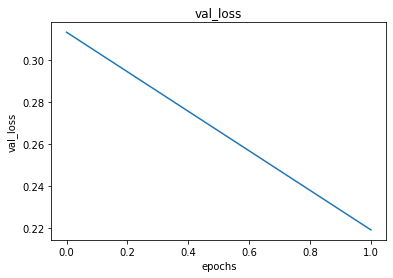

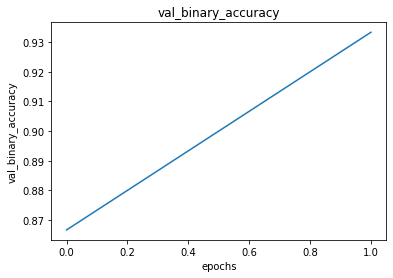

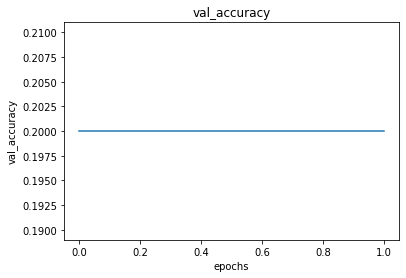

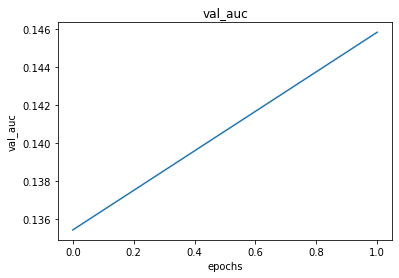

In [605]:
plot_training(history)

[0. 0. 0.]


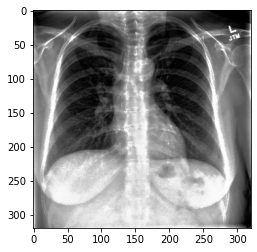

In [606]:
show_examples(train_ds, 1)